(gaussian_mixture_model)=
# Gaussian Mixture Model

:::{post} April, 2022
:tags: mixture model
:category: beginner, classification
:author: Benjamin T. Vincent
:::

A [mixture model](https://en.wikipedia.org/wiki/Mixture_model) allows us to make inferences about the component contributors to a distribution of data. More specifically, a Gaussian Mixture Model allows us to make inferences about the means and standard deviations of a specified number of underlying component Gaussian distributions.

This could be useful in a number of ways. For example, we may be interested in simply describing a complex distribution parametrically (i.e. a [mixture distribution](https://en.wikipedia.org/wiki/Mixture_distribution)). Alternatively, we may be interested in [classification](https://en.wikipedia.org/wiki/Classification) where we seek to probabilistically classify which of a number of classes a particular observation is from.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

First we generate some simulated observations.

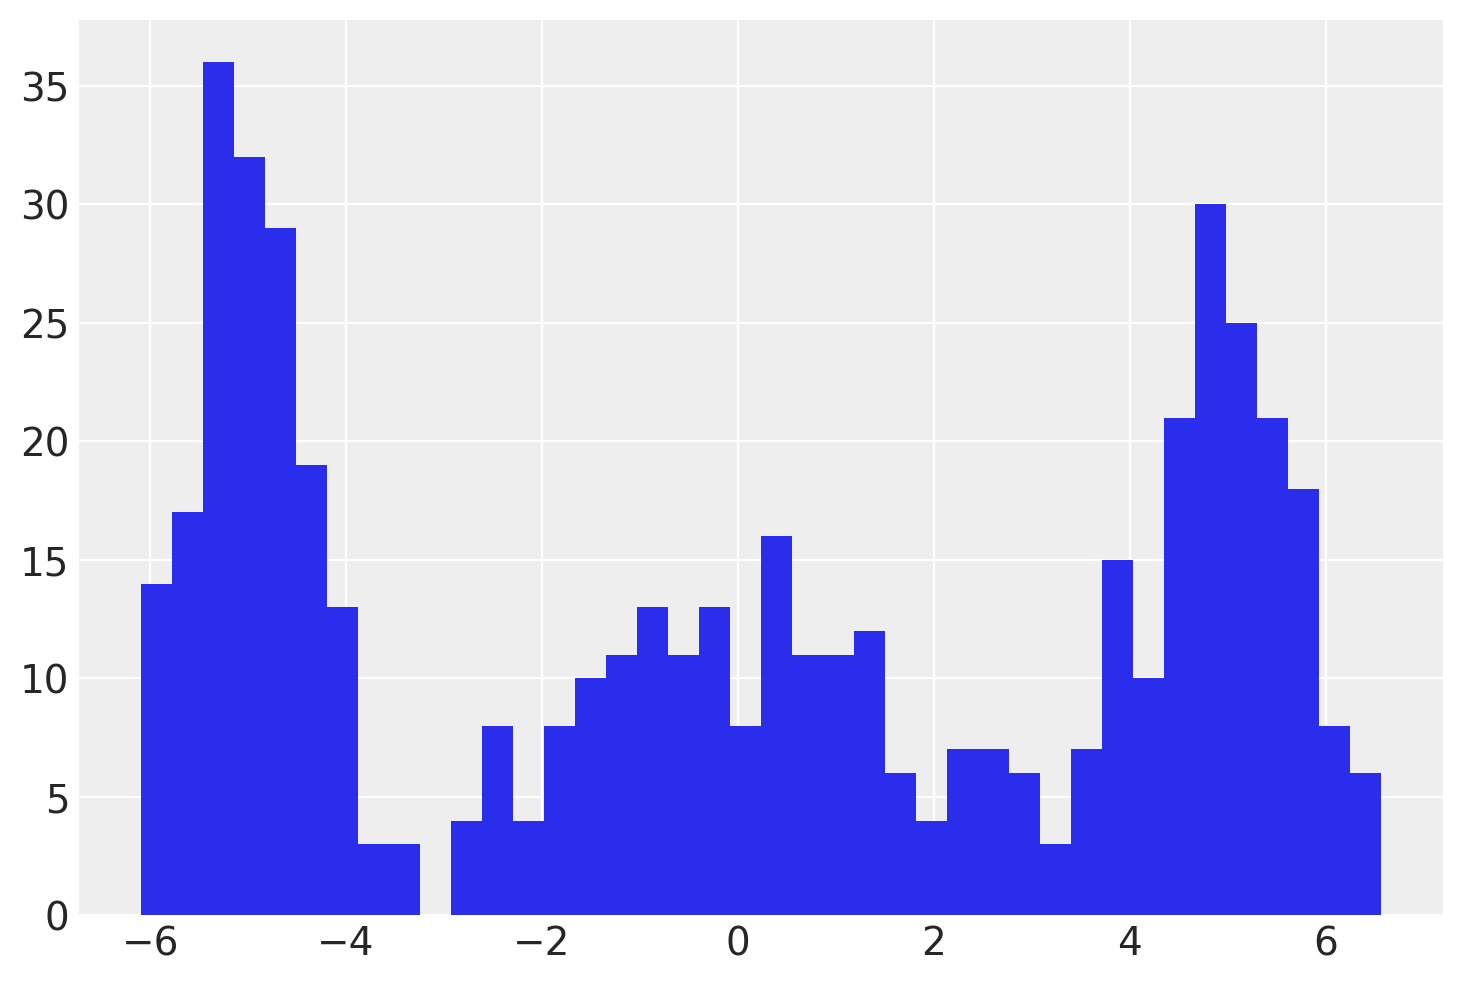

In [3]:
k = 3
ndata = 500
centers = np.array([-5, 0, 5])
sds = np.array([0.5, 2.0, 0.75])
idx = rng.integers(0, k, ndata)
x = rng.normal(loc=centers[idx], scale=sds[idx], size=ndata)
plt.hist(x, 40);

In the PyMC model, we will estimate one $\mu$ and one $\sigma$ for each of the 3 clusters. Writing a Gaussian Mixture Model got significantly easier from PyMC 4.0.0b6 onwards with the introduction of `pm.NormalMixture`.

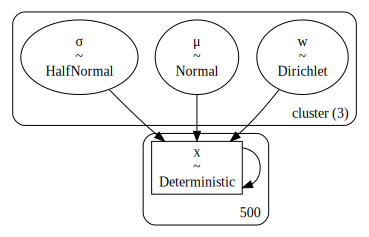

In [4]:
with pm.Model(coords={"cluster": range(k)}) as model:
    μ = pm.Normal(
        "μ",
        mu=0,
        sigma=5,
        transform=pm.distributions.transforms.ordered,
        initval=[-4, 0, 4],
        dims="cluster",
    )
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")
    pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=x)

pm.model_to_graphviz(model)

In [5]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/benjamv/opt/miniconda3/envs/pymc-dev-py39/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8839, but should be close to 0.8. Try to increase the number of tuning steps.


We can also plot the trace to check the nature of the MCMC chains, and compare to the ground truth values.

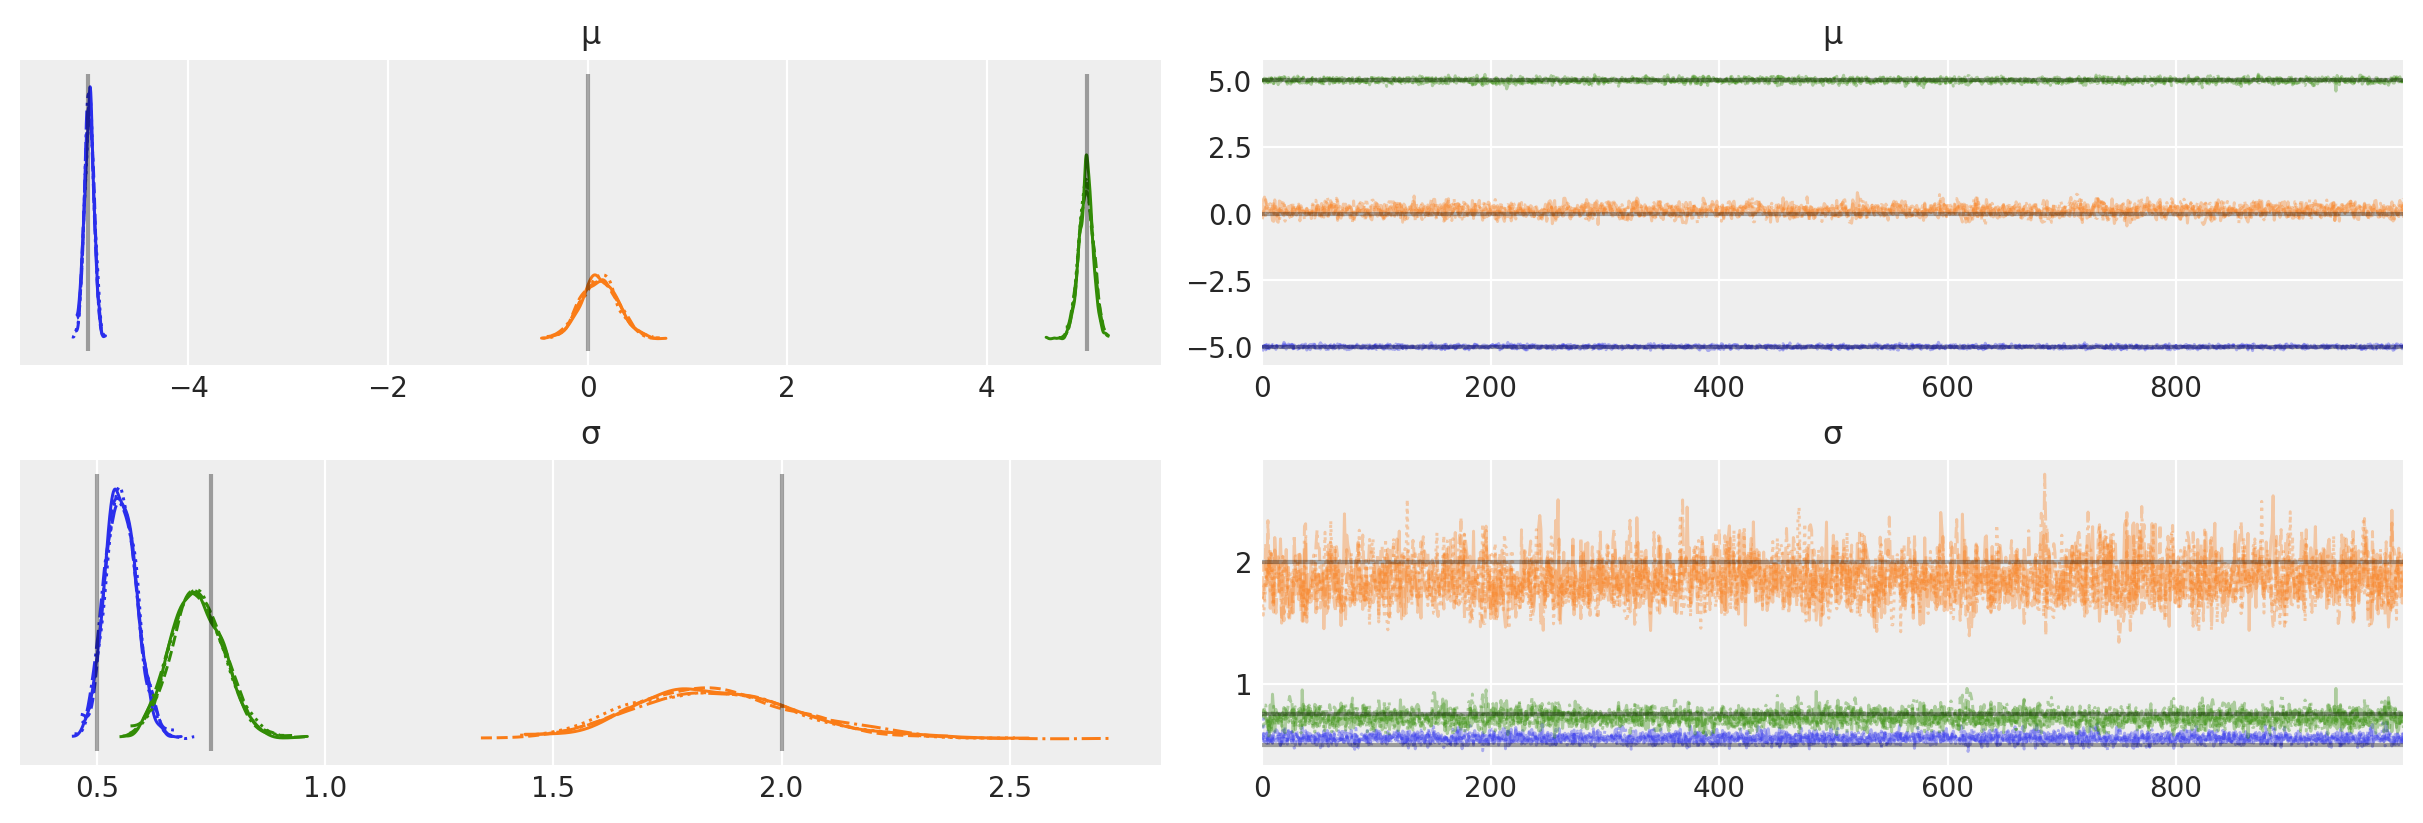

In [6]:
az.plot_trace(idata, var_names=["μ", "σ"], lines=[("μ", {}, [centers]), ("σ", {}, [sds])]);

And if we wanted, we could calculate the probability density function and examine the estimated group membership probabilities, based on the posterior mean estimates.

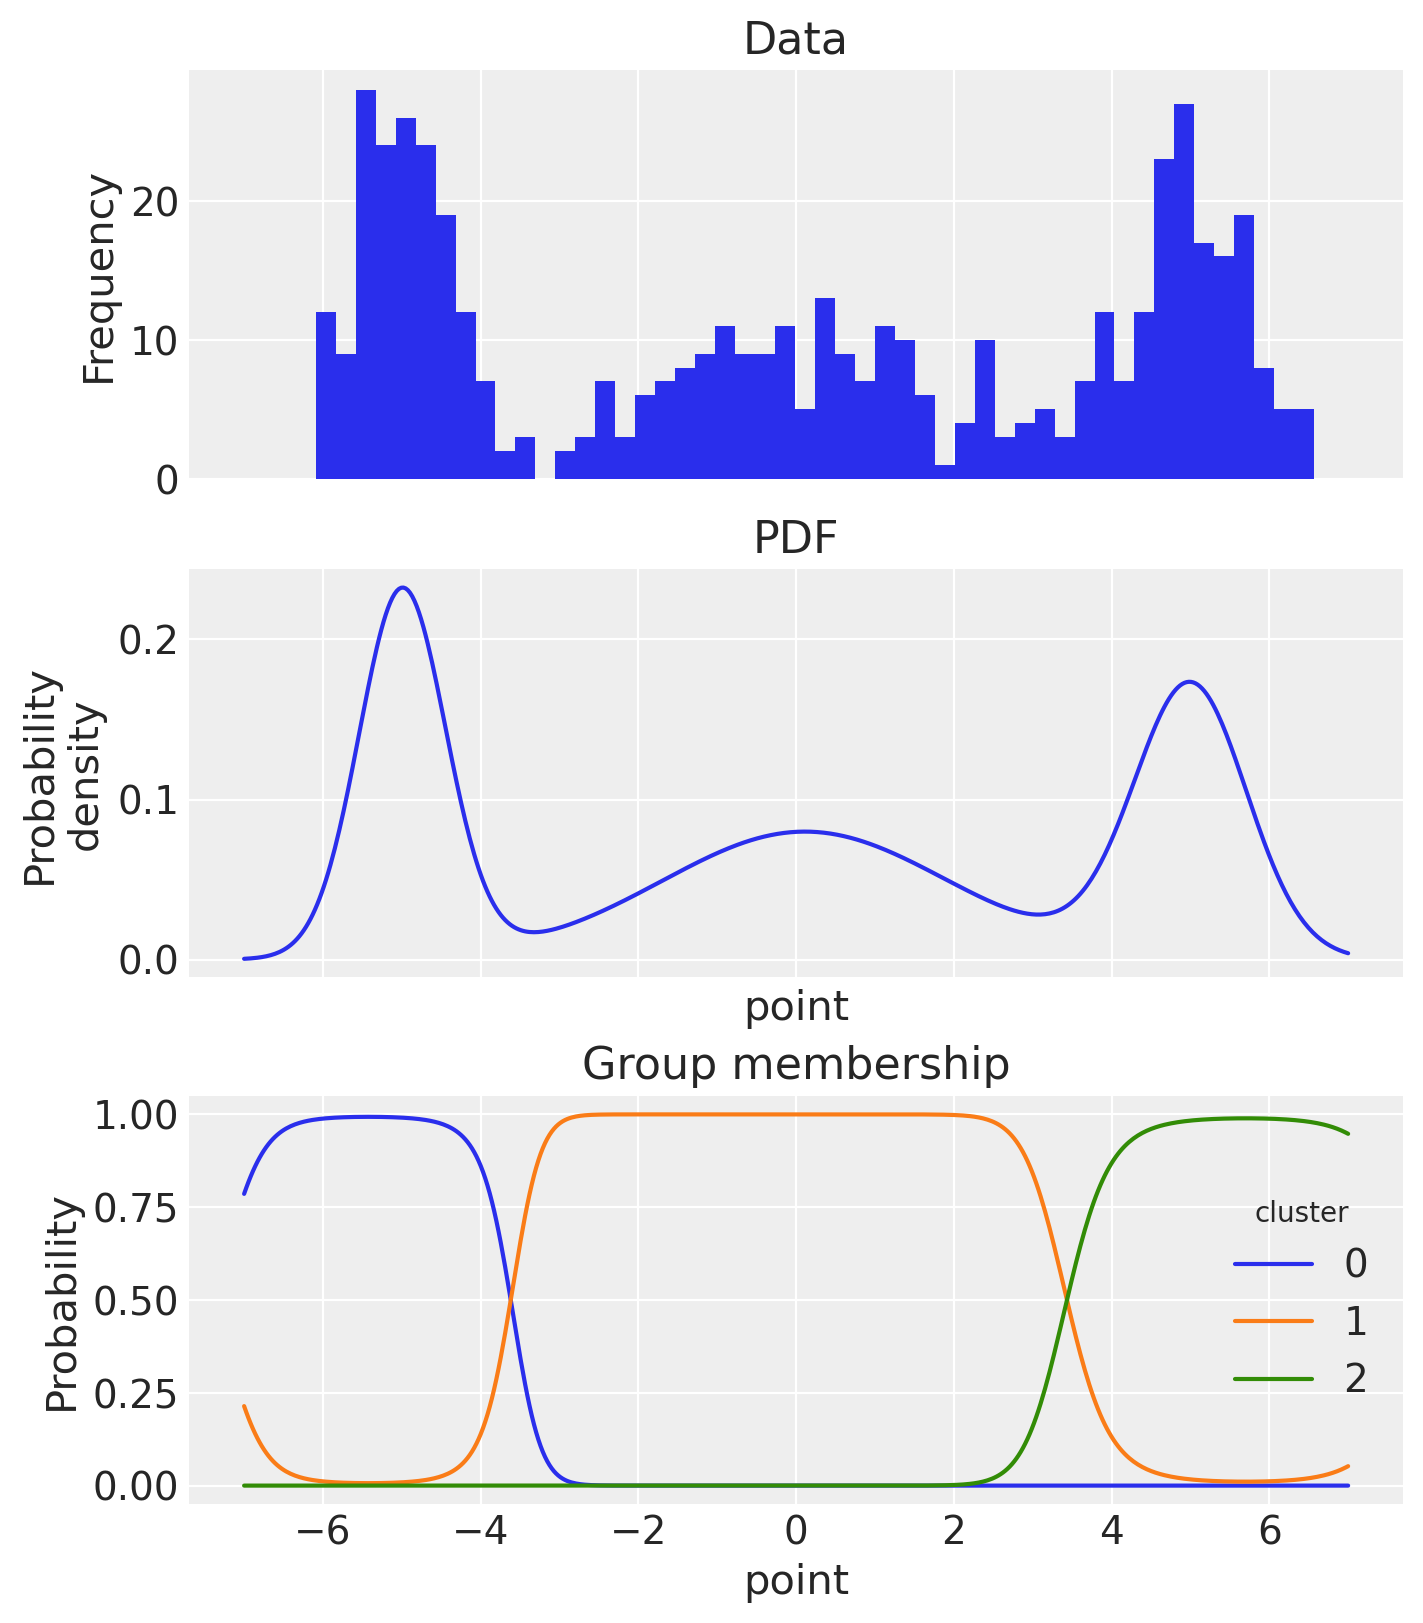

In [7]:
xi = np.linspace(-7, 7, 500)
post = idata.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["w"]
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
# empirical histogram
ax[0].hist(x, 50)
ax[0].set(title="Data", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", ylabel="Probability");

## Authors
- Authored by Abe Flaxman.
- Updated by Thomas Wiecki.
- Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) in April 2022 ([#310](https://github.com/pymc-devs/pymc-examples/pull/310)) to use `pm.NormalMixture`.

## Watermark

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Sat Apr 16 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.2.0

aesara: 2.5.1
aeppl : 0.0.27
xarray: 2022.3.0

pandas    : 1.4.2
arviz     : 0.12.0
matplotlib: 3.5.1
pymc      : 4.0.0b6
numpy     : 1.22.3

Watermark: 2.3.0



:::{include} ../page_footer.md
:::